# Multi-armed bandits

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Create a Bandit class representing the multi-armed bandit
class Bandit:
    def __init__(self, num_arms):
        # Initialize the Bandit object with the number of arms
        self.num_arms = num_arms
        # Generate true rewards for each arm from a standard normal distribution
        self.true_rewards = np.random.normal(0, 1, num_arms)
        
    def pull_arm(self, arm_index):
        # Simulate pulling an arm of the bandit and returning the reward
        # The reward is sampled from a normal distribution with mean equal to the true reward of the arm
        # and standard deviation of 1
        reward = np.random.normal(self.true_rewards[arm_index], 1)
        reward = 1 / (1 + np.exp(-reward))  # Apply sigmoid transformation
        return reward

Epsilon-Greedy:

- The epsilon-greedy algorithm is a fundamental exploration-exploitation strategy in multi-armed bandit problems.
- It aims to balance the exploration of uncertain arms and the exploitation of arms with high estimated rewards.
- The algorithm maintains estimated rewards, called q-values, for each arm based on observed rewards.
- With a probability epsilon, the algorithm chooses a random arm for exploration.
- With a probability of 1 - epsilon, it selects the arm with the highest estimated reward for exploitation.
- Epsilon determines the trade-off between exploration and exploitation, with higher values favoring exploration.

In [3]:
def epsilon_greedy(q_values, n_pulls, c, prior_wins, prior_losses, epsilon=0.1):
    num_arms = len(q_values)
    if np.random.random() < epsilon:
        # Explore: choose a random arm
        action = np.random.randint(num_arms)
    else:
        # Exploit: choose the arm with the highest q-value
        action = np.argmax(q_values)
    return action, None

UCB (Upper Confidence Bound):

- The UCB algorithm leverages upper confidence bounds to select arms for exploration and exploitation.
- It addresses the exploration-exploitation dilemma by considering both the estimated reward and the uncertainty associated with each arm.
- The algorithm maintains the number of times each arm has been pulled, denoted as n_pulls, and the estimated rewards, represented by q-values.
- It calculates the upper confidence bound for each arm using the exploration potential, determined by a parameter c and the logarithm of the total number of pulls.
- The arm with the highest upper confidence bound is chosen for exploitation, as it offers a balance between estimated reward and exploration potential.

In [4]:
def ucb(q_values, n_pulls, prior_wins, prior_losses, c=1.0):
    num_arms = len(q_values)
    exploration_term = np.zeros(num_arms)

    # Calculate the exploration term
    non_zero_n_pulls = n_pulls[n_pulls > 0]
    exploration_term[n_pulls > 0] = c * np.sqrt(np.log(sum(n_pulls[n_pulls > 0]) + 1e-6) / non_zero_n_pulls + 1e-6)
    exploration_term[n_pulls == 0] = float('inf')

    ucb_values = q_values + exploration_term
    action = np.argmax(ucb_values)
    return action, None

Thompson Sampling:

- Thompson Sampling is a Bayesian approach to multi-armed bandit problems that addresses exploration and exploitation.
- It maintains a distribution, typically a Beta distribution, over the true reward probabilities of each arm.
- In each round, it samples a reward probability from each arm's distribution and selects the arm with the highest sampled probability.
- The sampling process allows exploration of arms with uncertain reward probabilities, as it considers the entire distribution of each arm.
- The algorithm updates the distributions based on observed wins and losses for each arm, which helps refine the estimation over time.

In [5]:
def thompson_sampling(q_values, n_pulls, c, prior_wins, prior_losses):
    # Set a small epsilon value to avoid division by zero
    epsilon = 1e-6
    # Calculate the alpha and beta parameters for the Beta distribution
    alpha = np.maximum(prior_wins, epsilon)
    beta = np.maximum(prior_losses, epsilon)
    # Sample success rates from the Beta distribution
    success_rates = np.random.beta(alpha, beta)  # Remove the +1 term
    # Select the arm with the highest success rate
    action = np.argmax(success_rates)
    return action, None

Bayesian Greedy:

- Bayesian Greedy is another Bayesian approach that focuses on exploiting the current best arm while considering prior information.
- Similar to Thompson Sampling, it maintains a distribution over the true reward probabilities of each arm, often using a Beta distribution.
- The algorithm selects the arm with the highest expected reward based on the mean of the reward probability distribution.
- It updates the mean reward probabilities using Bayesian inference, incorporating prior information and observed wins and losses.
- By considering prior knowledge and the observed data, Bayesian Greedy provides a balance between exploration and exploitation.

In [6]:
def bayesian_greedy(q_values, n_pulls, c, prior_wins=1, prior_losses=1):
    num_arms = len(q_values)
    
    posterior_wins = prior_wins + np.sum(n_pulls, axis=0)
    posterior_losses = prior_losses + np.sum(1 - n_pulls, axis=0)
    
    # Calculate the mean win rate for each arm
    win_rates = posterior_wins / (posterior_wins + posterior_losses)
    
    # Select the arm with the highest mean win rate
    action = np.argmax(win_rates)
    
    return action, None

Horizon-Aware UCB:
- The Horizon-Aware UCB algorithm is an extension of the UCB algorithm that takes into account the horizon or the total number of episodes in the multi-armed bandit experiment.
- It aims to balance exploration and exploitation by adjusting the exploration term based on the horizon.
- The key idea behind HA-UCB is to increase the exploration term as the number of episodes increases, allowing for more exploration early on and gradually shifting towards exploitation as the experiment progresses.

In [15]:
def ucb_horizon_aware(q_values, n_pulls, prior_wins, prior_losses, horizon=num_episodes, c=1.0):
    num_arms = len(q_values)
    exploration_term = np.zeros(num_arms)
    # Calculate the exploration term for arms with non-zero number of pulls
    exploration_term[n_pulls > 0] = c * np.sqrt(2 * np.log(horizon) / n_pulls[n_pulls > 0])
    exploration_term[n_pulls == 0] = float('inf')
    ucb_values = q_values + exploration_term
    # Select the arm with the highest UCB value
    action = np.argmax(ucb_values)
    return action, None

In [13]:
# Set up the multi-armed bandit experiment variables
num_arms = 5
num_episodes = 1000
true_means = np.random.normal(0, 1, num_arms)
epsilon = 0.1
c = 1.0

# Initialize the bandit and q-values
bandit = Bandit(num_arms)
q_values = np.zeros(num_arms)
n_pulls = np.zeros(num_arms)

# Define the list of algorithms to test
algorithms = [
    (epsilon_greedy, 'Epsilon-Greedy'),
    (ucb, 'UCB'),
    (thompson_sampling, 'Thompson Sampling'),
    (bayesian_greedy, 'Bayesian Greedy'),
    (ucb_horizon_aware, 'HA-UCB')
]

# Initialize a dictionary to store the cumulative rewards for each algorithm
cumulative_rewards = {algorithm_name: [] for _, algorithm_name in algorithms}
average_rewards = {algorithm_name: [] for _, algorithm_name in algorithms}

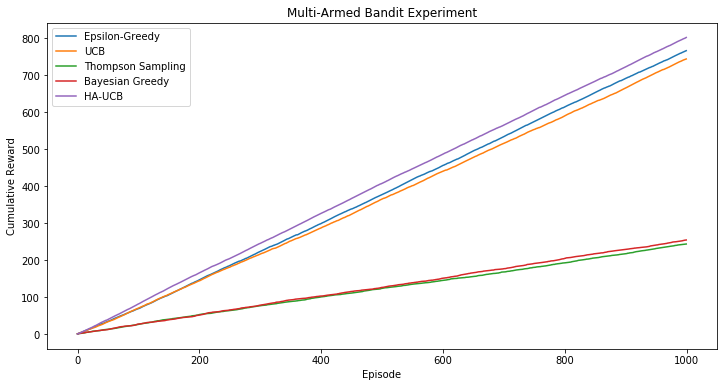

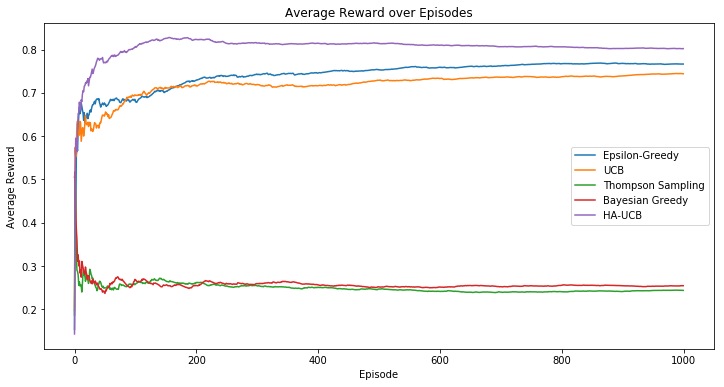

In [14]:
# Run the multi-armed bandit experiment for each algorithm
for algorithm_func, algorithm_name in algorithms:
    rewards = []
    n_pulls = np.zeros(num_arms)
    q_values = np.zeros(num_arms)
    prior_wins = 1
    prior_losses = 1
    for episode in range(num_episodes):
        action, _ = algorithm_func(q_values, n_pulls, c, prior_wins, prior_losses)
        reward = bandit.pull_arm(action)
        rewards.append(reward)
        n_pulls[action] += 1
        q_values[action] += (reward - q_values[action]) / n_pulls[action]
        average_reward = np.mean(rewards)
        average_rewards[algorithm_name].append(average_reward)
    cumulative_rewards[algorithm_name] = np.cumsum(rewards)

# Plot the results of the multi-armed bandit experiment for different algorithms
plt.figure(figsize=(12,6))
for algorithm_name, cumulative_reward in cumulative_rewards.items():
    plt.plot(cumulative_reward, label=algorithm_name)

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Multi-Armed Bandit Experiment')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for algorithm_name, avg_rewards in average_rewards.items():
    plt.plot(avg_rewards, label=algorithm_name)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward over Episodes')
plt.legend()
plt.show()